# Playground 8:  Segmentation workflows for filamentous structures

This notebook contains the workflows for Tight junction protein ZO1, Beta actin, Non-muscle myosin IIB, Alpha-actinin-1, Alpha tubulin, Troponin I, and Titin. It also serves as a starting point for developing a classic segmentation workflow for your data with filamentous structures.

----------------------------------------

Cell Structure Observations:

* [Tight junction protein ZO1](https://www.allencell.org/cell-observations/category/zo1)

* [Actin-structures (Beta actin, Alpha-actinin-1 and Non-muscle myosin IIB)](https://www.allencell.org/cell-observations/category/actin-structures)

* [Alpha tubulin](https://www.allencell.org/cell-observations/category/microtubule)

* [Troponin I](https://www.allencell.org/cell-observations/category/troponin)

* [Titin](https://www.allencell.org/cell-observations/category/titin)

----------------------------------------

Key steps of the workflows:

* Auto-contrast intensity normalization
* Smoothing (mostly edge-preserving smoothing, except 3d gaussian for ZO1)
* 3D filament filter
* size thresholding


In [6]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_3d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, edge_preserving_smoothing_3d, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects    

## Loading the data

In [3]:
FILE_NAME =  '../demo_data/TNNI1_demo_data.tif'
reader = AICSImage(FILE_NAME) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

(1, 1, 60, 441, 555)


## Preview of the image

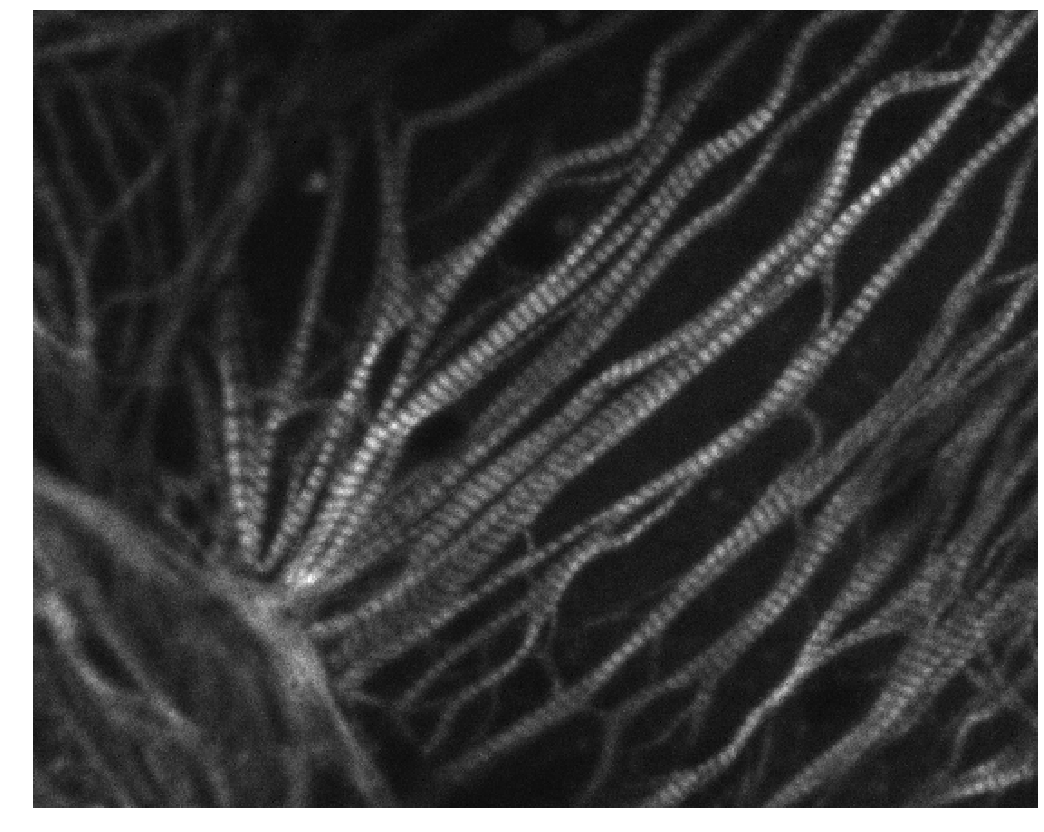

In [4]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [5]:
#####################
## PARAMETER ##
structure_channel = 0
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * Parameter for ZO1:  `intensity_scaling_param = [3, 17]`
    * Parameter for beta actin:  `intensity_scaling_param = [3, 15]`
    * Parameter for myosin:  `intensity_scaling_param = [2.5, 17]`
    * Parameter for Alpha-actinin-1:  `intensity_scaling_param = [3, 15]`
    * Parameter for Alpha tubulin:  `intensity_scaling_param = [1.5, 8]`
    * Parameter for Troponin:  `intensity_scaling_param = [2, 11]`
    * Parameter for Titin:  `intensity_scaling_param = [8, 15.5]`


* **Smoothing** 

    * For Beta actin, Non-muscle myosin IIB, Alpha-actinin-1, Alpha tubulin, Troponin I, and Titin: `edge_preserving_smoothing()`, no parameter
    * For ZO1: 3D gaussian smoothing with `gaussian_smoothing_sigma = 1`. The large the value is, the more the image will be smoothed.

In [7]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [0]
################################
# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with edge preserving smoothing 
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

#### for ZO1
# gaussian_smoothing_sigma = 1
# structure_img_smooth = image_smoothing_gaussian_3d(structure_img, sigma=gaussian_smoothing_sigma)

intensity normalization: using min-max normalization with NO absolute intensity upper bound
intensity normalization completes


In [8]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = `

In [9]:
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(struct_img0)

mean intensity of the stack: 137.08819580078125
the standard deviation of intensity of the stack: 54.570411682128906
0.9999 percentile of the stack intensity is: 693.0
minimum intensity of the stack: 34.0
maximum intensity of the stack: 992.0
suggested upper range is 10.5, which is 710.0775184631348
suggested lower range is 1.5, which is 55.23257827758789
So, suggested parameter for normalization is [1.5, 10.5]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


### Step 2: Core Algorithm

#### Apply F3 filter

* Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
    * `scale_x` is set based on the estimated thickness of your target filaments. For example, if visually the thickness of the filaments is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have filaments of very different thickness.  
    * `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more filaments, especially detecting more dim ones and thicker segmentation, while larger `cutoff_x` could be less permisive and yield less filaments and slimmer segmentation.


* Parameter for ZO1: `[[1.5, 0.2]]`
* Parameter for Beta actin: `[[2,0.1],[1,0.04]]`
* Parameter for Myosin: `[[2,0.2],[1,0.015]]`
* Parameter for Alpha-actinin-1: `[[2,0.15], [1,0.05]]`
* Parameter for Alpha-tubulin: `[[1,0.01]]`
* Parameter for Troponin I : `[[1, 0.01]]`
* Parameter for Titin: `[[1, 0.02]]`

In [10]:
################################
## PARAMETERS for this step ##
f3_param = [[1, 0.01]]
################################

bw = filament_3d_wrapper(structure_img_smooth, f3_param)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [12]:
viewer_bw =view(segmentation_quick_view(bw))
viewer_bw

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side
##### You may select an ROI to inspect the details

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_bw'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [13]:
# Option 1:
view(seg_fluo_side_by_side(struct_img,bw,roi=['ROI',viewer_bw.roi_slice()]))

# Option 2: 
#view(seg_fluo_side_by_side(struct_img,bw,roi=['M',[70,70,130,140]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

#### If the segmentation is satisfactory, go to Step 3; otherwise, you can tune parameters to improve the performance. Follow the steps below:

--------------------------
1. If you see lots of mis-detection --> try to decrease `cutoff`
2. If the algorithm detects too much, much thicker than it should be or lots of background noise --> try to increase `cutoff`
3. If the algorithm only detects all those major filaments (i.e., missing tenuous filaments) --> try use or add a smaller `scale`
4. If the major filaments are detected as over fragmented --> try use or add a larger `scale`
------------------------------

#### Step 3: Post-Processing 

In [15]:
################################
## PARAMETERS for this step ##
minArea = 4
################################

seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [17]:
viewer_final = view(segmentation_quick_view(seg))
viewer_final

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

### You can also focus your inspection on a small ROI

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_final'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [18]:
# Option 1: 
view(seg_fluo_side_by_side(struct_img, seg, roi=['ROI',viewer_final.roi_slice()]))

# Option 2: 
# view(seg_fluo_side_by_side(struct_img, seg, roi=['M',[67,74, 188, 205]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

### You may also physically save the segmentation results into a .tiff file

In [27]:
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('../../data/TNNI1/result/demo_test_segmentation.tiff')
writer.save(out)